In [62]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from aerobot.io import RESULTS_PATH, DATA_PATH, FEATURE_TYPES
from aerobot.dataset import dataset_load_feature_order
from aerobot.models import GeneralClassifier
from aerobot.plot import plot_configure_mpl, plot_color_palette
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticks
from scipy.stats import linregress

plot_configure_mpl(figure_height=3)

In [63]:
earth_microbiome_df = pd.read_csv(os.path.join(DATA_PATH, 'earth_microbiome', 'aerobe_anaerobe_fraction.csv'))
black_sea_df = pd.read_csv(os.path.join(DATA_PATH, 'black_sea', 'black_sea.csv'))

# Figure 2

In [64]:
def plot_figure_2a(earth_microbiome_df:pd.DataFrame, grid:GridSpec=None, fig:plt.Figure=None):

    # Create a new axis in the grid.
    ax = fig.add_subplot(grid)
    # Convert fraction columns to percentages.
    for col in earth_microbiome_df.columns:
        if 'fraction' in col:
            earth_microbiome_df[col.replace('fraction', 'percent')] = earth_microbiome_df[col] * 100
    cols = ['habitat', 'anaerobe_percent', 'aerobe_percent', 'facultative_percent']
    earth_microbiome_df = earth_microbiome_df[(earth_microbiome_df.total > 240) & ~earth_microbiome_df.habitat.str.match('Host-associated')]
    earth_microbiome_df = earth_microbiome_df[cols].set_index('habitat').sort_values('anaerobe_percent', ascending=False)
    earth_microbiome_df.plot(kind='bar', stacked=True, ax=ax, legend=False, edgecolor='k', linewidth=0.5)
    ax.legend(['Anaerobe', 'Aerobe', 'Facultative'], loc=3)
    # ax.legend(mean_fractions_df.prediction.unique(), loc=3)
    ax.set_ylabel('percent of MAGs in samples')
    ax.set_xlabel('')
    ax.set_xticks(np.arange(len(earth_microbiome_df.index)), labels=earth_microbiome_df.index.values, rotation=45, ha='right')
    ax.set_ylim(0, 100.1)
    ax.yaxis.set_major_formatter(ticks.PercentFormatter())

    return ax

In [65]:
def plot_figure_2b(black_sea_df:pd.DataFrame, grid:GridSpec=None, fig:plt.Figure=None):

    # Define a new sub-grid from the original grid. 
    sub_grid = GridSpecFromSubplotSpec(1, 2, wspace=0.3, hspace=0.2, subplot_spec=grid)
    ax_1 = fig.add_subplot(sub_grid[0, 0])
    ax_2 = fig.add_subplot(sub_grid[0, 1])

    ax_1.invert_yaxis()  # Invert the axis, so surface is at the top. 
    ax_2.invert_yaxis()  # Invert the axis, so surface is at the top. 
    ax_2.set_yscale('log'), ax_2.set_yscale('log') # Convert depth axis to logscale.
    ax_2.set_yticks([])
    ax_1.set_ylabel('depth (m)')

    ax_1.set_xscale('log') # Convert x-axis to logscale.
    ax_1.set_xticks([1, 100], labels=[1, 100])
    ax_1.set_xlabel('concentration ($\mu$M)')
    
    kwargs = {'markersize':5, 'lw':0.75, 'markeredgecolor':'w', 'ls':'-', 'marker':'o',}
    ax_1.plot(black_sea_df.h2s_uM, black_sea_df.depth_m,  color=plot_color_palette()['red'], label='H$_2$S', **kwargs)
    ax_1.plot(black_sea_df.o2_uM, black_sea_df.depth_m, color=plot_color_palette()['yellow'],label='O$_2$', **kwargs)

    ax_2.set_xlabel('relative abundance')
    ax_2.plot(black_sea_df['aerobe'], black_sea_df.depth_m, color=plot_color_palette()['green'], label='aerobe', **kwargs)
    ax_2.plot(black_sea_df['anaerobe'], black_sea_df.depth_m, color=plot_color_palette()['purple'], label='anaerobe', **kwargs)

    return ax_1

<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_595978/3472268815.py:16: SyntaxWarning: invalid escape sequence '\m'
  ax_1.set_xlabel('concentration ($\mu$M)')


In [68]:
def plot_figure_2c(black_sea_df:pd.DataFrame, grid:GridSpec=None, fig:plt.Figure=None):

    # Create an axis in the specified grid space.
    ax = fig.add_subplot(grid)

    # Perform regression analysis of O2/H2S ratio vs. aerobe/anaerobe ratio
    o2_h2s_ratio = black_sea_df.o2_uM / black_sea_df.h2s_uM
    aerobe_anaerobe_ratio = black_sea_df.aerobe / black_sea_df.anaerobe

    # Perform linear regression on the log-transformed data. 
    log_o2_h2s_ratio = np.log10(o2_h2s_ratio)
    log_aerobe_anaerobe_ratio = np.log10(aerobe_anaerobe_ratio)

    # Do linear regression on the log ratios.
    reg = linregress(log_aerobe_anaerobe_ratio, log_o2_h2s_ratio)
    x_vals = np.logspace(log_aerobe_anaerobe_ratio.min(), log_aerobe_anaerobe_ratio.max(), 100)
    y_vals = reg.intercept + reg.slope * np.log10(x_vals)

    ax.loglog(aerobe_anaerobe_ratio.values, o2_h2s_ratio.values, marker='o', ls='', color='grey', markerfacecolor='w', markeredgecolor='k')
    ax.plot(x_vals, 10**y_vals, color='k', ls='--', lw=0.75, zorder=-1)

    # Bootstrap a confidence interval plot manually because seaborns regplot doesn't handle log scale...
    for _ in range(1000):
        slope = np.random.normal(reg.slope, reg.stderr)
        intercept = np.random.normal(reg.intercept, reg.intercept_stderr)
        y_vals = intercept + slope * np.log10(x_vals)
        ax.plot(x_vals, 10**y_vals, color=plot_color_palette()['blue'], ls='-', lw=0.5, zorder=-10)

    ax.set_xlabel('inferred aerobe/anaerobe ratio')
    ax.set_ylabel('[O$_2$]/[H$_2$S] ratio')
    ax.text(0.98, 0.03, '$\\rho$ = {0:.2f}, $P < 10^{{-6}}$'.format(reg.rvalue, reg.pvalue), transform=ax.transAxes, ha='right', va='bottom')

    return ax

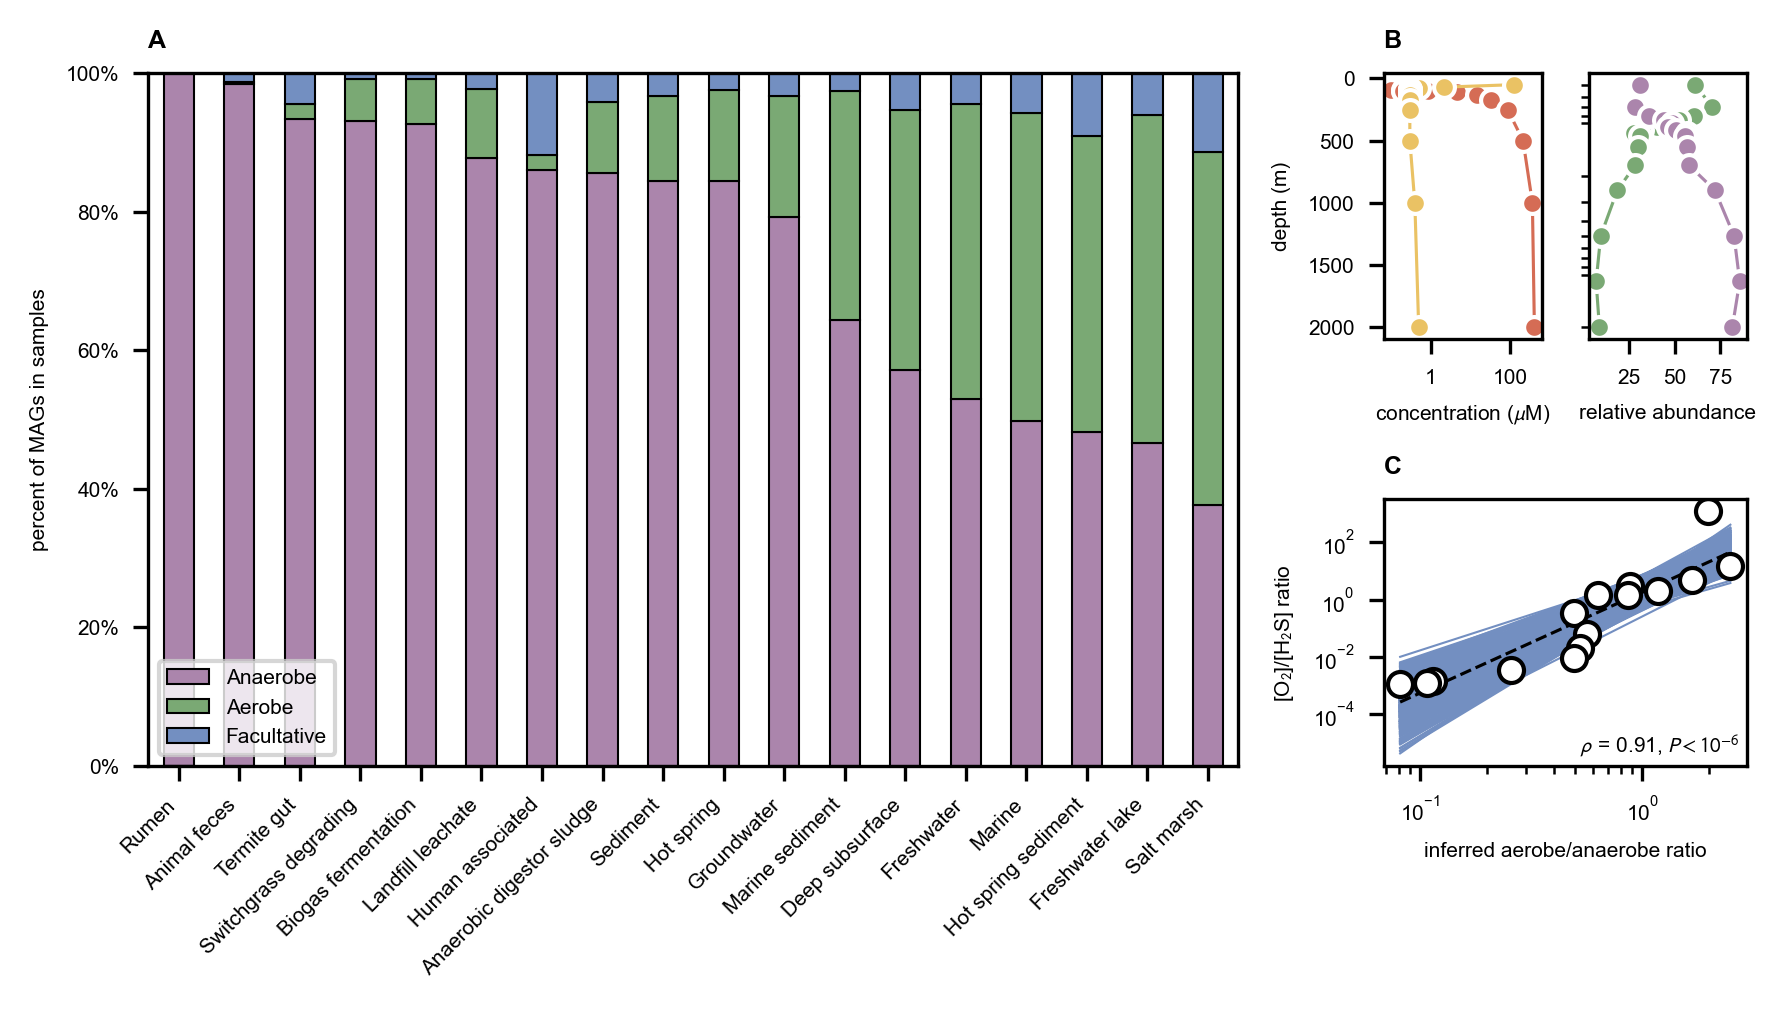

In [69]:
fig = plt.figure()
grid = GridSpec(2, 2, width_ratios=(3, 1), wspace=0.2, hspace=0.6)

axes = []
axes.append(plot_figure_2a(earth_microbiome_df, grid=grid[0:, 0], fig=fig))
axes.append(plot_figure_2b(black_sea_df, grid=grid[0, 1], fig=fig))
axes.append(plot_figure_2c(black_sea_df, grid=grid[1, 1:], fig=fig))

for ax, ax_label in zip(axes, 'ABC'):
    if ax is not None:
        ax.set_title(ax_label, loc='left', fontweight='bold')

plt.show()
